# Analysis of conditional GAN results

In [1]:
# Convenient fudge for python path
import sys
sys.path.append('..')

In [23]:
# Compatibility
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# System
import os
import json

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Locals
from atlasgan import cgan
from atlasgan.datasets import RPVCondImages, inverse_transform_data, generate_noise
from atlasgan.reco import compute_physics_variables

# Magics
%matplotlib notebook

## Load the data

In [3]:
def load_model_config(train_dir):
    config_file = os.path.join(train_dir, 'config.json')
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def load_validation_metrics(metrics_file):
    return pd.DataFrame(dict(np.load(metrics_file)))

In [4]:
# Directory containing all of the training directories we want to process
train_dir = '/data0/sfarrell/atlas_gan/AtlasCondGAN_001'

In [5]:
test_masses = [(1400, 850), (1600, 850), (1800, 850)]
test_files = [
    '/data0/sfarrell/atlas_gan/data/RPV10_1400_850_01_test.npz',
    '/data0/sfarrell/atlas_gan/data/RPV10_1600_850_01_test.npz',
    '/data0/sfarrell/atlas_gan/data/RPV10_1800_850_01_test.npz'
]
metrics_files = [
    os.path.join(train_dir, os.path.basename(f).replace('test', 'metrics'))
    for f in test_files
]

In [18]:
n_test = 4096
datasets = [RPVCondImages(f, n_samples=n_test) for f in test_files]

## Evaluate results

In [6]:
results = []
for (mglu, mneu), metrics_file in zip(test_masses, metrics_files):
    results.append(load_validation_metrics(metrics_file).assign(mglu=mglu, mneu=mneu))
results = pd.concat(results, ignore_index=True)

In [7]:
# Add the combined KS metric
ks_comb = results.ks_jetPt + results.ks_nJet + results.ks_sumMass
results = results.assign(ks_comb=ks_comb)

In [8]:
# Show the best model epochs across all HPs using the combined KS metric
top_k = 10
idx = results.ks_comb.sort_values().index[:top_k]
topk_results = results.loc[idx]
topk_results

,epoch,ks_jetEta,ks_jetPhi,ks_jetPt,ks_nJet,ks_sumMass,mglu,mneu,ks_comb
93,29,86.702208,67.480504,24.323100,2.223362,30.241376,1600,850,56.787838
183,55,214.595496,52.804479,10.920564,15.393541,37.025739,1800,850,63.339845
43,43,75.861426,109.176622,23.065579,42.813029,19.104948,1400,850,84.983556
78,14,112.470168,171.461126,37.991499,22.141085,27.349572,1600,850,87.482155
3,3,291.274147,278.066877,26.123030,37.605278,30.590916,1400,850,94.319224
0,0,431.688093,326.601357,51.231593,17.201134,32.188147,1400,850,100.620873
173,45,131.831833,263.112930,37.962733,48.133448,19.950324,1800,850,106.046505
100,36,303.427933,98.986455,16.859471,14.444787,76.147313,1600,850,107.451570
170,42,309.227839,77.168126,51.331072,28.523133,30.415901,1800,850,110.270105
76,12,126.463552,185.243188,59.402628,49.013189,3.648857,1600,850,112.064674


In [69]:
# Sort by sumMass performance
idx = results.ks_sumMass.sort_values().index[:top_k]
results.loc[idx]

,epoch,ks_jetEta,ks_jetPhi,ks_jetPt,ks_nJet,ks_sumMass,mglu,mneu,ks_comb
76,12,126.463552,185.243188,59.402628,49.013189,3.648857,1600,850,112.064674
71,7,35.469772,219.812434,36.172591,93.967600,3.846945,1600,850,133.987136
153,25,204.142613,143.026714,91.351273,421.833785,5.128263,1800,850,518.313320
101,37,358.496605,97.751368,187.039003,19.153685,8.345863,1600,850,214.538552
136,8,149.069885,159.790625,14.576948,88.855825,8.833041,1800,850,112.265814
75,11,197.417224,116.172654,377.929559,82.737159,9.824714,1600,850,470.491431
83,19,337.959818,50.506461,122.767444,303.925937,10.338959,1600,850,437.032340
41,41,88.292087,184.538192,82.953589,27.682421,10.443281,1400,850,121.079291
160,32,126.945513,271.799412,192.054380,12.978182,10.865478,1800,850,215.898040
168,40,62.632893,95.187654,200.521922,78.778325,13.445544,1800,850,292.745792


In [74]:
# Try to select the best sumMass for both mglu 1400 and 1800, then test it below on 1600
results[results.mglu != 1600].groupby('epoch').ks_sumMass.sum().sort_values()

epoch
0      116.651404
12     125.975085
7      157.443246
19     160.134752
14     169.753235
29     177.059944
11     184.198265
37     191.524910
35     191.670661
15     198.229443
48     198.605738
41     200.269244
28     201.494450
6      214.288149
13     214.515939
38     226.841883
16     233.077389
36     241.638416
55     266.813141
57     280.294972
47     295.267257
44     308.734606
50     311.539516
32     319.733330
17     323.132507
45     327.716535
43     341.908983
18     360.134394
56     367.643610
39     372.048451
         ...     
61     426.753132
23     445.544117
52     445.871372
8      484.449082
40     522.452460
51     526.179577
53     545.572576
46     558.083926
21     579.443168
5      581.585573
9      609.235551
26     632.690805
3      670.121517
34     699.308587
63     777.940820
54     795.625041
33     855.106893
4      871.682045
24     872.093687
10     885.953286
20     925.054868
60     967.872274
49     969.930239
59     975.109517
62  

## Load a model and evaluate on the test sets

In [15]:
def load_model(train_dir, checkpoint_id, model_config):
    """Load generator and discriminator from checkpoint"""
    checkpoint_file = os.path.join(
        train_dir, 'checkpoints', 'model_checkpoint_%03i.pth.tar' % checkpoint_id
    )
    # Load the checkpoint and map onto CPU
    checkpoint = torch.load(checkpoint_file, map_location=lambda storage, loc: storage)
    generator = cgan.Generator(noise_dim=model_config['noise_dim'],
                               cond_dim=model_config['cond_dim'],
                               threshold=model_config['threshold'],
                               n_filters=model_config['n_filters'])
    discriminator = cgan.Discriminator(n_filters=model_config['n_filters'],
                                       cond_dim=model_config['cond_dim'])
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    # Ensure the model is in eval mode
    return generator.eval(), discriminator.eval()

In [78]:
epoch = 0 #12 #29

model_config = load_model_config(train_dir)
generator, discriminator = load_model(train_dir, checkpoint_id=epoch, model_config=model_config)

In [79]:
%%time

real_images, fake_images = [], []
real_vars, fake_vars = [], []

scale = model_config['image_norm']
for dataset in datasets:
    print(dataset.cond.numpy())
    # Real images and reconstructed physics variables
    test_real = Variable(dataset.data, volatile=True)
    test_cond = Variable(dataset.cond.repeat(n_test, 1))
    real_images.append(inverse_transform_data(dataset.data.numpy().squeeze(1), scale=scale))
    real_vars.append(compute_physics_variables(real_images[-1]))
    
    # Generated images and reconstructed physics variables
    test_noise = Variable(generate_noise(n_test, model_config['noise_dim']), volatile=True)
    test_fake = generator(test_noise, test_cond)
    fake_images.append(inverse_transform_data(test_fake.data.numpy().squeeze(1), scale=scale))
    fake_vars.append(compute_physics_variables(fake_images[-1]))

[0.         0.42857143]
[0.4        0.42857143]
[0.8        0.42857143]
CPU times: user 56.1 s, sys: 1.56 s, total: 57.6 s
Wall time: 34.6 s


<IPython.core.display.Javascript object>


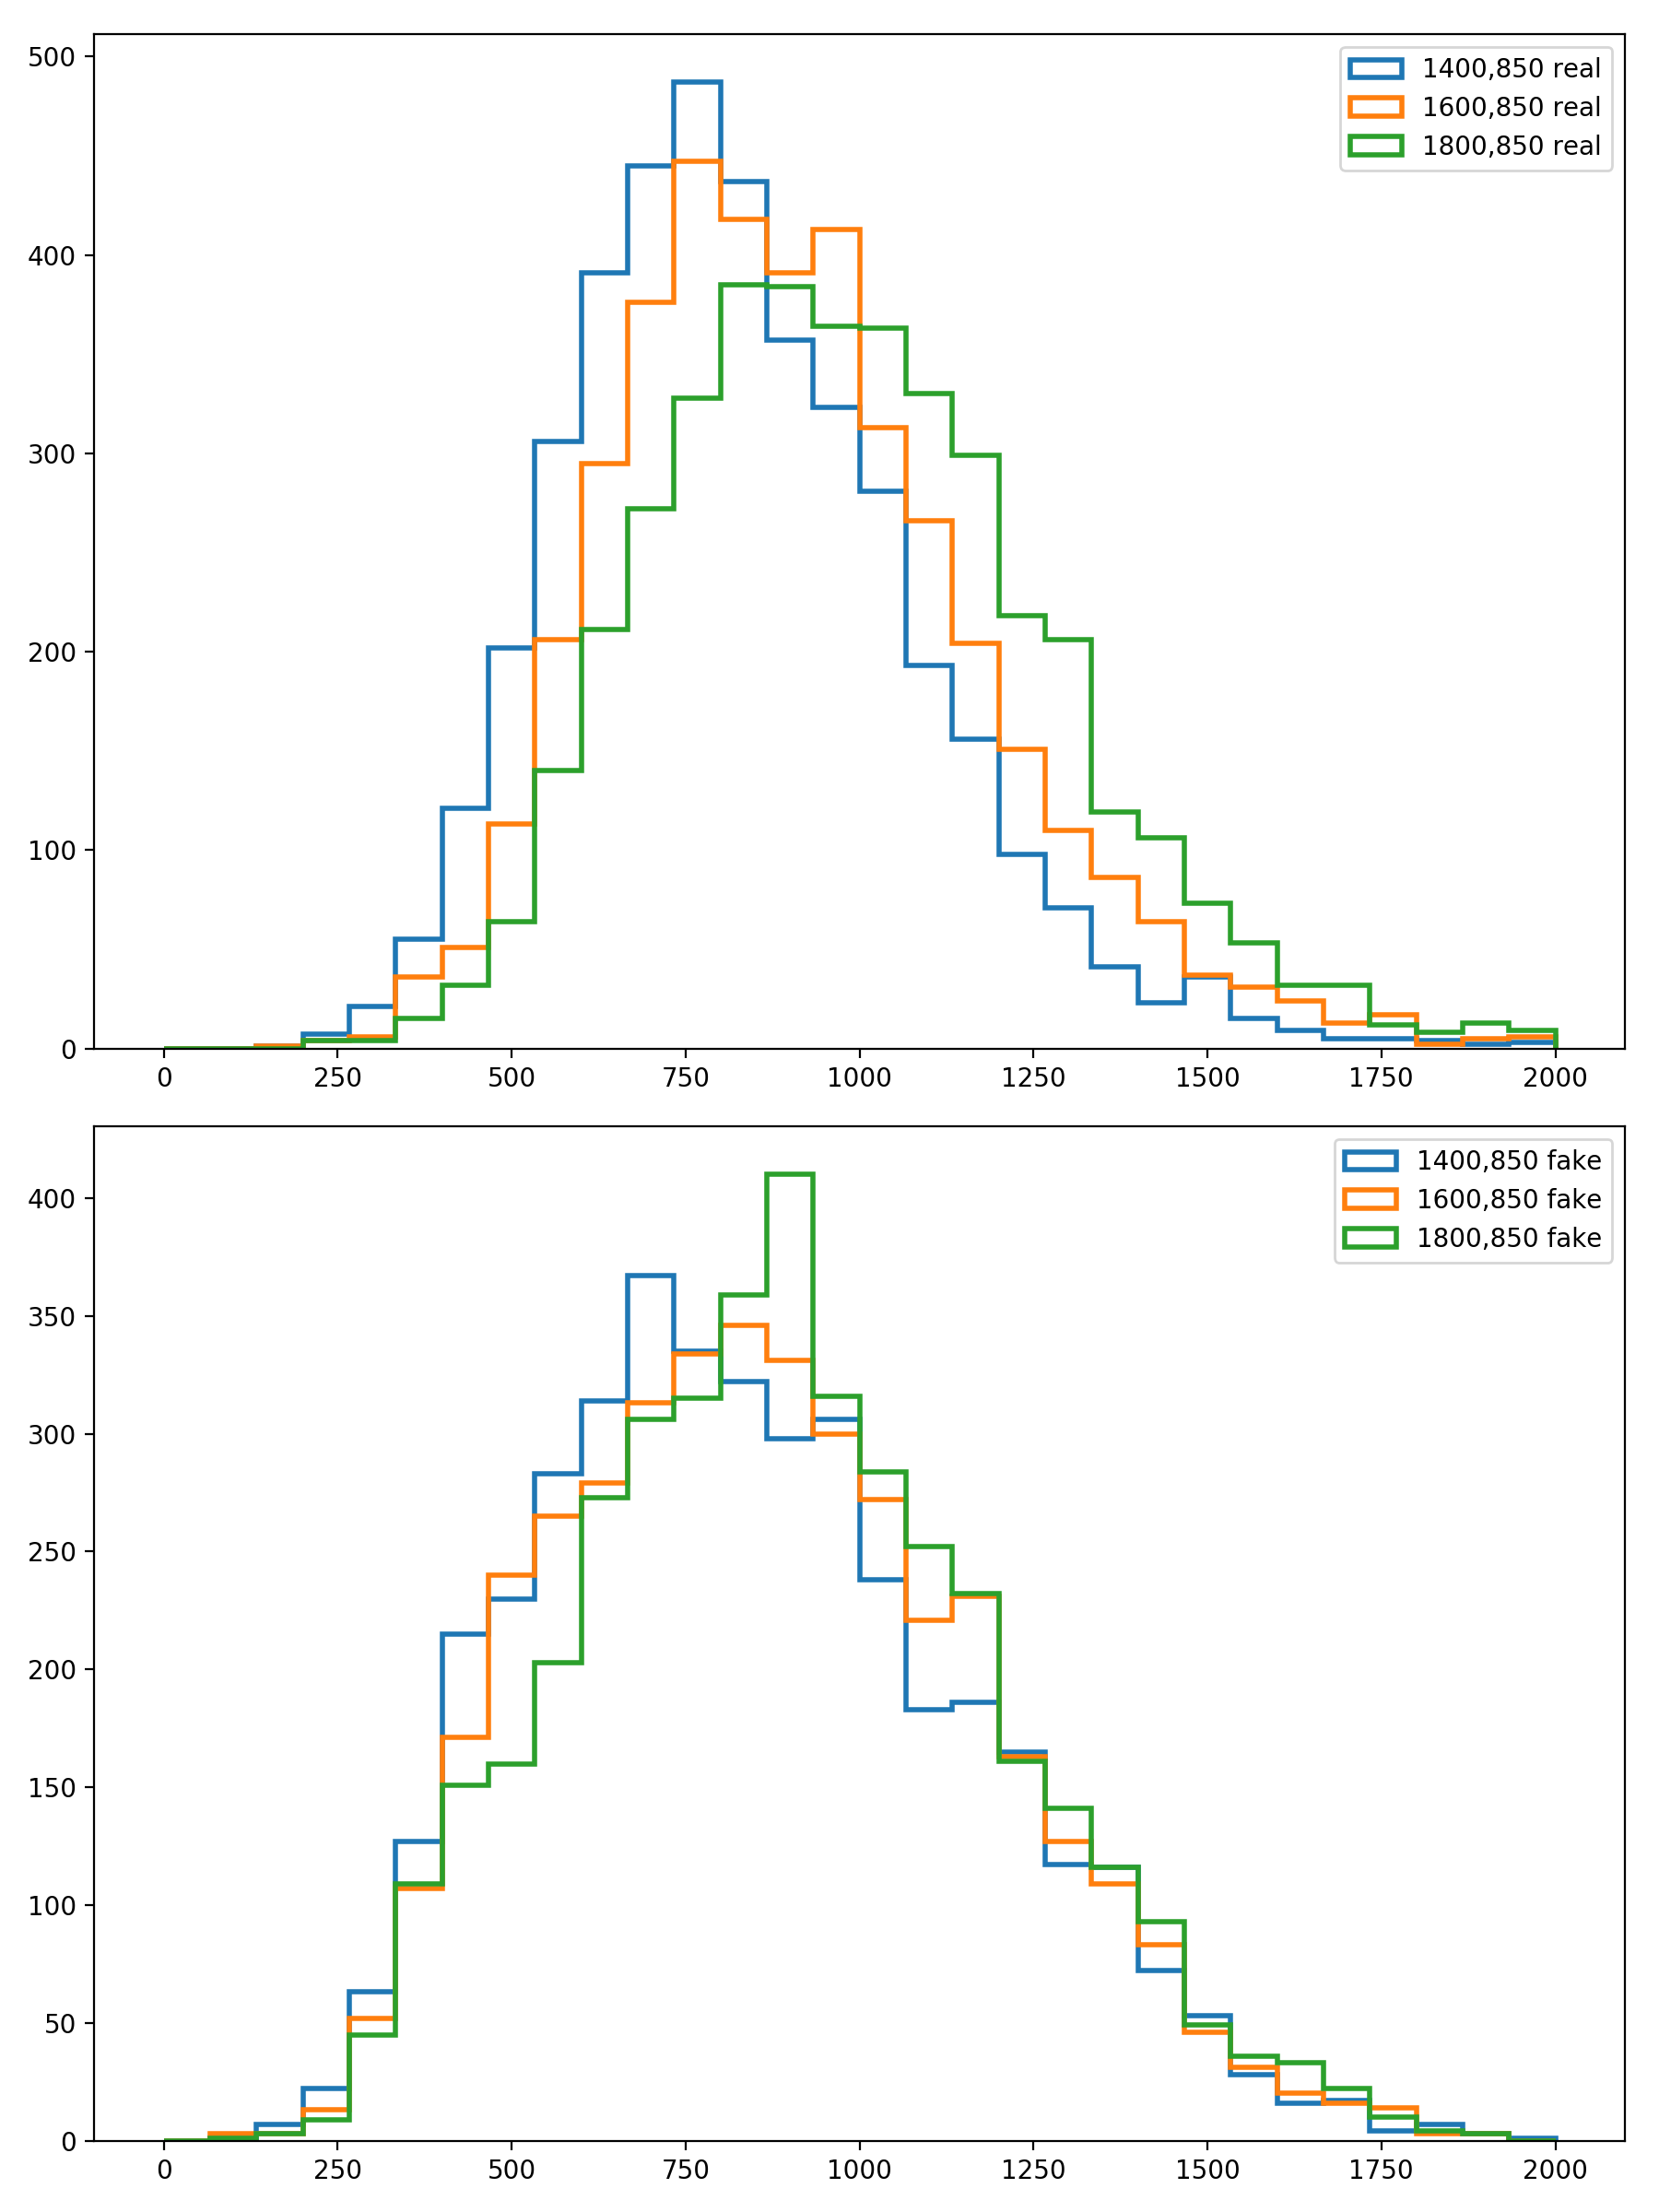

In [80]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 12))

#colors = ['b', 'g', 'r']
hist_args = dict(bins=30, range=(0, 2e3), log=False, histtype='step', linewidth=2)
for i in range(len(real_vars)):
    # Draw real distributions
    ax0.hist(real_vars[i]['sumMass']*1e-3,
             label='%i,%i real' % test_masses[i], **hist_args)
    # Draw generated distributions
    ax1.hist(fake_vars[i]['sumMass']*1e-3,
             label='%i,%i fake' % test_masses[i], **hist_args)
    

plt.tight_layout()
ax0.legend(loc=0)
ax1.legend(loc=0)